# **CSV Upload**

In [27]:
# 1. Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Veriyi Yükleme
# index_col='Date': Tarih sütununu satır başlığı (index) yapar.
# parse_dates=True: Tarihlerin yazı değil, zaman nesnesi olarak okunmasını sağlar.
try:
    df = pd.read_csv('stocks_hazir_veri.csv', index_col='Date', parse_dates=True)
    print("✅ Veri başarıyla yüklendi!")
    print(df.head()) # İlk 5 satırı görelim
except FileNotFoundError:
    print("❌ HATA: Dosya bulunamadı! Lütfen sol menüdeki dosyalar kısmına csv dosyasını yüklediğinden emin ol.")

✅ Veri başarıyla yüklendi!
                Close       High        Low       Open     Volume  RSI  \
Date                                                                     
2022-01-03  30.062765  30.651625  29.727414  29.757357  391547000  NaN   
2022-01-04  29.233376  30.409098  28.294195  30.218467  527154000  NaN   
2022-01-05  27.550631  29.359128  27.479769  28.893029  498064000  NaN   
2022-01-06  28.123524  28.383021  27.012676  27.586564  454186000  NaN   
2022-01-07  27.194326  28.367056  27.004693  28.086599  409939000  NaN   

                MACD  MACD_Signal  BB_Middle  BB_Upper  BB_Lower  
Date                                                              
2022-01-03  0.000000     0.000000        NaN       NaN       NaN  
2022-01-04 -0.066162    -0.013232        NaN       NaN       NaN  
2022-01-05 -0.251481    -0.060882        NaN       NaN       NaN  
2022-01-06 -0.348106    -0.118327        NaN       NaN       NaN  
2022-01-07 -0.493967    -0.193455        NaN       N

In [28]:
# 1. Eksik verileri (NaN) temizle
print("Temizlik öncesi satır sayısı:", len(df))

df.dropna(inplace=True)

print("Temizlik sonrası satır sayısı:", len(df))
print("✅ İlk satırlardaki NaN değerler atıldı, tablo artık eğitim için hazır.")

# Kontrol edelim
print(df.head())

Temizlik öncesi satır sayısı: 1003
Temizlik sonrası satır sayısı: 984
✅ İlk satırlardaki NaN değerler atıldı, tablo artık eğitim için hazır.
                Close       High        Low       Open     Volume        RSI  \
Date                                                                           
2022-01-31  24.438662  24.461618  23.007434  23.137182  564680000  40.211753   
2022-02-01  24.590364  25.096384  23.843810  25.055463  518925000  41.323155   
2022-02-02  25.193197  25.767084  24.505528  25.744130  543419000  45.646965   
2022-02-03  23.901703  25.028520  23.734028  24.410717  410178000  39.014091   
2022-02-04  24.271984  24.587373  23.586312  23.925655  354829000  41.632773   

                MACD  MACD_Signal  BB_Middle   BB_Upper   BB_Lower  
Date                                                                
2022-01-31 -1.711528    -1.547199  25.720428  30.670986  20.769870  
2022-02-01 -1.553948    -1.548549  25.446808  29.973614  20.920001  
2022-02-02 -1.364690  

# **Scaling**

In [29]:
from sklearn.preprocessing import MinMaxScaler

# 1.SÜTUN LİSTESİ
# Modelin öğrenmesini istediğimiz en kritik verileri seçiyoruz.
# High/Low/Open yerine indikatörleri kullanmak genelde daha iyi sonuç verir.
features = ['Close', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower']

print(f"\nKullanılacak Özellikler ({len(features)} adet): {features}")

# 2. Veriyi Seçiyoruz (.values ile numpy formatına çeviriyoruz)
data_matrix = df[features].values

# 3. Ölçekleyiciyi (Scaler) Kuruyoruz
# Veriyi 0 ile 1 arasına sıkıştırıyoruz ki LSTM şaşırmasın.
scaler = MinMaxScaler(feature_range=(0, 1))

# 4. İşlemi Uyguluyoruz
scaled_data = scaler.fit_transform(data_matrix)

# --- SONUÇ KONTROLÜ ---
print("\n📊 Scaling İşlemi Başarılı!")
print(f"Orijinal İlk Satır (Fiyatlar 24$ civarı):\n {data_matrix[0]}")
print(f"Ölçeklenmiş İlk Satır (0-1 Arası):\n {scaled_data[0]}")


Kullanılacak Özellikler (5 adet): ['Close', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower']

📊 Scaling İşlemi Başarılı!
Orijinal İlk Satır (Fiyatlar 24$ civarı):
 [24.43866158 40.21175319 -1.71152755 30.67098556 20.76987042]
Ölçeklenmiş İlk Satır (0-1 Arası):
 [0.06754191 0.21274742 0.28357487 0.08814803 0.0594818 ]


# **Windowing**

In [30]:
import numpy as np

# --- AYARLAR ---
LOOKBACK_WINDOW = 60  # Model geçmiş kaç güne bakarak karar versin? (Genelde 60 idealdir)
FUTURE_TARGET = 0     # Hangi sütunu tahmin edeceğiz? (0. sütunumuz 'Close' yani Fiyat)

def create_dataset(dataset, look_back=60):
    """
    Veriyi LSTM için uygun 3 boyutlu hale getirir.
    X: Geçmiş veriler (Örn: Son 60 gün)
    y: Hedef veri (Örn: Yarınki fiyat)
    """
    X, y = [], []
    for i in range(look_back, len(dataset)):
        # i-60'tan i'ye kadar olan veriyi al (Geçmiş)
        X.append(dataset[i-look_back:i, :])

        # i. gündeki Fiyatı al (Hedef - Sadece 0. sütun yani 'Close')
        y.append(dataset[i, FUTURE_TARGET])

    return np.array(X), np.array(y)

# Fonksiyonu çalıştır
X, y = create_dataset(scaled_data, LOOKBACK_WINDOW)

# --- KONTROL ---
print("✅ Veri Seti Oluşturuldu!")
print(f"X (Girdiler) Boyutu: {X.shape}")
print(f"y (Hedefler) Boyutu: {y.shape}")

# Beklenen Çıktı Örneği:
# X Boyutu: (950, 60, 5) -> 950 adet örnek, her biri 60 günlük, her günde 5 özellik var.
# y Boyutu: (950,) -> 950 adet hedef fiyat.

✅ Veri Seti Oluşturuldu!
X (Girdiler) Boyutu: (924, 60, 5)
y (Hedefler) Boyutu: (924,)


# **Train/Test Split**

In [31]:
# 1. Ayrım Noktasını Belirle (%80 Eğitim, %20 Test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

print(f"Toplam Veri: {len(X)}")
print(f"Ayrım {split_index}. sıradan yapılacak.")

# 2. Bıçağı Vur ve Ayır (Slicing)
# 0'dan split_index'e kadar olanlar -> EĞİTİM (Train)
X_train = X[:split_index]
y_train = y[:split_index]

# split_index'ten sona kadar olanlar -> TEST (Test)
X_test = X[split_index:]
y_test = y[split_index:]

# --- KONTROL ---
print("\n✅ Ayrıştırma Tamamlandı!")
print(f"Eğitim Seti (X_train): {X_train.shape} -> Model bunları ezberleyecek.")
print(f"Test Seti   (X_test):  {X_test.shape}  -> Model bunları HİÇ görmeyecek (Sınav Kağıdı).")
print(f"Hedefler    (y_train): {y_train.shape}")
print(f"Hedefler    (y_test):  {y_test.shape}")

Toplam Veri: 924
Ayrım 739. sıradan yapılacak.

✅ Ayrıştırma Tamamlandı!
Eğitim Seti (X_train): (739, 60, 5) -> Model bunları ezberleyecek.
Test Seti   (X_test):  (185, 60, 5)  -> Model bunları HİÇ görmeyecek (Sınav Kağıdı).
Hedefler    (y_train): (739,)
Hedefler    (y_test):  (185,)


# **Model'in Mimarisi**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Modeli Başlat (Boş bir kutu oluştur)
model = Sequential()

# 2. BİRİNCİ LSTM KATMANI (Giriş Katmanı)
# units=50: Bu katmanda 50 tane nöron (beyin hücresi) çalışacak.
# return_sequences=True: "Ben işimi bitirmedim, arkamdaki LSTM katmanına veri aktaracağım" der.
# input_shape: (60, 5) -> Bizim hazırladığımız dosya boyutu.
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout (%20): Nöronların %20'sini rastgele kapat. (Ezberi bozmak için)
model.add(Dropout(0.2))

# 3. İKİNCİ LSTM KATMANI (Ara Katman)
# return_sequences=False: "Artık arkamda başka LSTM yok, veriyi özetleyip bitiriyorum" der.
model.add(LSTM(units=50, return_sequences=False))

# Yine Dropout
model.add(Dropout(0.2))

# 4. DENSE KATMANLARI (Sonuç Çıkarma)
model.add(Dense(units=25)) # Ara bir işlem katmanı (Düşünceyi pişirme)
model.add(Dense(units=1))  # FİNAL: Tek bir çıktı (Tahmin edilen Fiyat)

# 5. DERLEME (Compiling) - Beyne nasıl öğreneceğini söylüyoruz
# optimizer='adam': Hataları düzeltmek için kullanılan çok popüler bir matematikçi (algoritma).
# loss='mean_squared_error': "Hatayı nasıl ölçeyim?" (Gerçek fiyat ile tahmin arasındaki farkın karesi).
model.compile(optimizer='adam', loss='mean_squared_error')

# --- ÖZET ---
print("🧠 Model Mimarisi Kuruldu!")
model.summary() # Modelin kimlik kartını ekrana basar

🧠 Model Mimarisi Kuruldu!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [33]:
# --- EĞİTİMİ BAŞLAT ---

# epochs=20: Model tüm veriyi baştan sona 20 kere okuyacak. (Ders çalışma tekrar sayısı)
# batch_size=32: Her seferinde 32 tane dosyayı aynı anda işleyecek. (Grup çalışması)
# validation_data: Her turun sonunda, hiç görmediği Test setiyle kendini sınayacak.

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

print("\n🎓 Eğitim Tamamlandı!")

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 0.0370 - val_loss: 0.0047
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0034 - val_loss: 0.0077
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0023 - val_loss: 0.0109
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0

# **Training Graph**

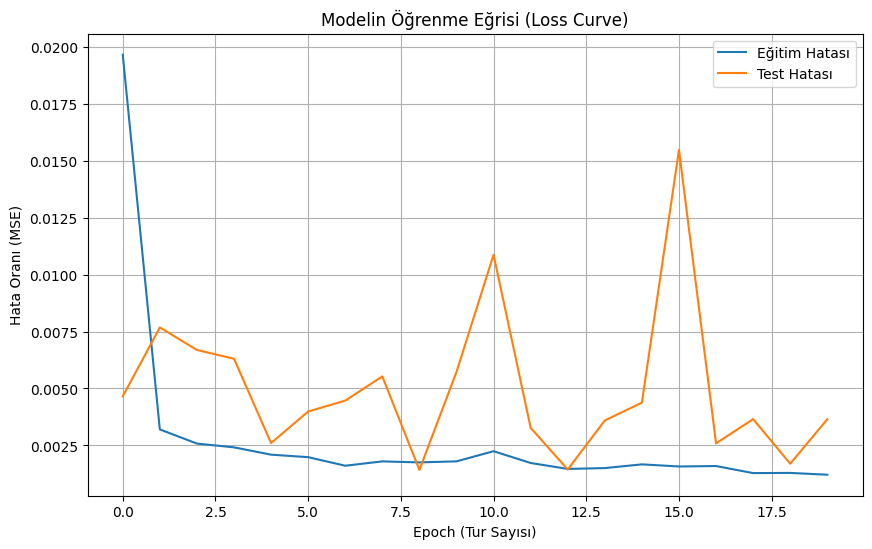

In [34]:
# Hata (Loss) grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Hatası')
plt.plot(history.history['val_loss'], label='Test Hatası')
plt.title('Modelin Öğrenme Eğrisi (Loss Curve)')
plt.ylabel('Hata Oranı (MSE)')
plt.xlabel('Epoch (Tur Sayısı)')
plt.legend()
plt.grid(True)
plt.show()

#**TAHMİN VE GERÇEK DÜNYA TESTİ**


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


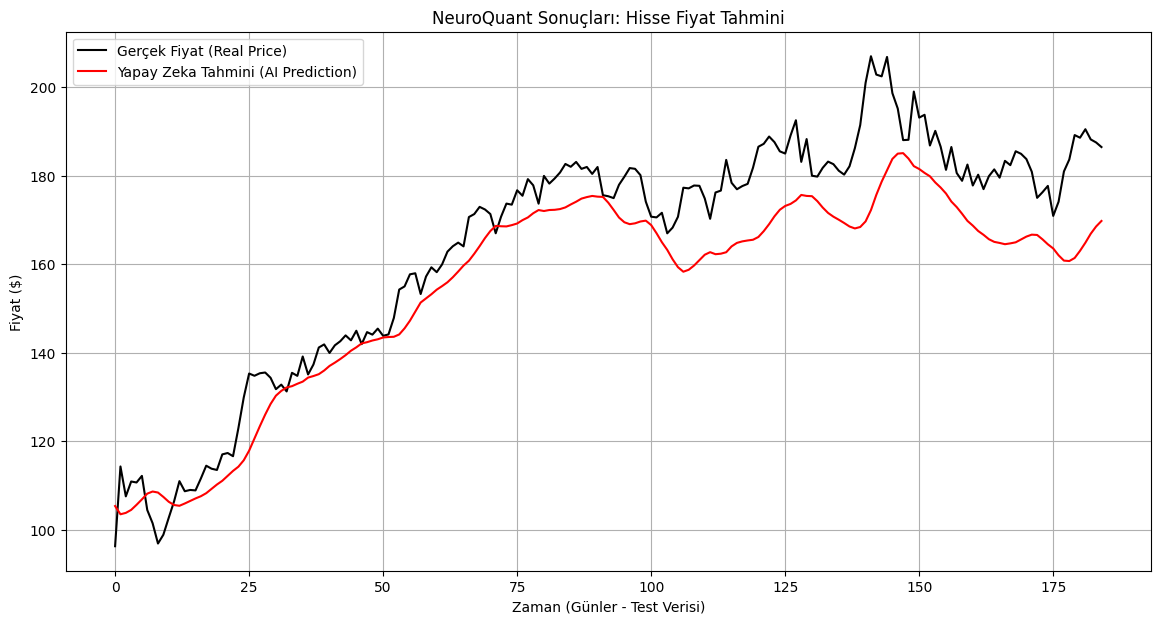


🔍 Son 5 Günün Karnesi:
Gün -1: Gerçek: 186.50$ | Tahmin: 169.80$ | Fark: 16.70$
Gün -2: Gerçek: 187.54$ | Tahmin: 168.55$ | Fark: 18.99$
Gün -3: Gerçek: 188.22$ | Tahmin: 166.91$ | Fark: 21.31$
Gün -4: Gerçek: 190.53$ | Tahmin: 164.88$ | Fark: 25.65$
Gün -5: Gerçek: 188.61$ | Tahmin: 163.04$ | Fark: 25.57$


In [35]:
# 1. Modelden tahminleri iste (0-1 arasında sayılar gelecek)
predictions = model.predict(X_test)

# --- INVERSE TRANSFORM (Eski Haline Çevirme) ---
# Scaler bizden 5 sütun bekliyor (Çünkü eğitirken 5 sütun verdik: Fiyat, RSI, MACD vs.)
# Ama elimizde sadece 1 sütun (Tahmin Fiyatı) var.
# Hata almamak için "Sahte Matris" (Dummy Matrix) yöntemi kullanacağız.

# Tahminler için boş bir tepsi (matris) oluştur
dummy_predictions = np.zeros((len(predictions), 5)) # len(predictions): Sütun sayısı 190,  5: Senin özellik sayın
dummy_predictions[:, 0] = predictions.flatten() # 0. sütuna tahminleri koy
inversed_predictions = scaler.inverse_transform(dummy_predictions)[:, 0] # Sadece fiyatı geri al

# Gerçek veriler (y_test) için de aynısını yap
dummy_y_test = np.zeros((len(y_test), 5))
dummy_y_test[:, 0] = y_test
inversed_y_test = scaler.inverse_transform(dummy_y_test)[:, 0]

# --- BÜYÜK GRAFİK ---
plt.figure(figsize=(14, 7))
plt.plot(inversed_y_test, color='black', label='Gerçek Fiyat (Real Price)')
plt.plot(inversed_predictions, color='red', label='Yapay Zeka Tahmini (AI Prediction)')
plt.title(f'NeuroQuant Sonuçları: {TICKER if "TICKER" in locals() else "Hisse"} Fiyat Tahmini')
plt.xlabel('Zaman (Günler - Test Verisi)')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.grid(True)
plt.show()

# Sayısal Olarak Son 5 Güne Bakalım
print("\n🔍 Son 5 Günün Karnesi:")
for i in range(1, 6):
    gercek = inversed_y_test[-i]
    tahmin = inversed_predictions[-i]
    fark = gercek - tahmin
    print(f"Gün {-i}: Gerçek: {gercek:.2f}$ | Tahmin: {tahmin:.2f}$ | Fark: {fark:.2f}$")

# **Hata Analizi**

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Hatırlatma: inversed_y_test (Gerçek) ve inversed_predictions (Tahmin) değişkenleri elimizdeydi.

# 1. MAE (Mean Absolute Error) - Ortalama Mutlak Hata
# "Ortalama kaç dolar yanılıyoruz?" (Yönüne bakmadan)
mae = mean_absolute_error(inversed_y_test, inversed_predictions)

# 2. RMSE (Root Mean Squared Error) - Kök Ortalama Kare Hata
# Bu daha kritiktir. Büyük hatalara (ani fiyat patlamalarına) daha çok ceza verir.
rmse = math.sqrt(mean_squared_error(inversed_y_test, inversed_predictions))

# 3. MAPE (Mean Absolute Percentage Error) - Yüzdesel Hata
# "Yüzde kaç yanılıyoruz?"
mape = np.mean(np.abs((inversed_y_test - inversed_predictions) / inversed_y_test)) * 100

print(f"📉 MODEL KARNESİ:")
print(f"-------------------------")
print(f"Ortalama Sapma (MAE) : {mae:.2f} $")
print(f"Kritik Hata (RMSE)   : {rmse:.2f} $")
print(f"Yüzdesel Hata (MAPE) : %{mape:.2f}")

# Yorum
print(f"-------------------------")
print(f"Yorum: Modelimiz ortalama %{mape:.2f}'lik bir sapma ile tahmin yapıyor.")

📉 MODEL KARNESİ:
-------------------------
Ortalama Sapma (MAE) : 9.74 $
Kritik Hata (RMSE)   : 11.83 $
Yüzdesel Hata (MAPE) : %5.73
-------------------------
Yorum: Modelimiz ortalama %5.73'lik bir sapma ile tahmin yapıyor.


# **GELECEK TAHMİNİ (FORECASTING)**

In [37]:

# 1. Veri setinin EN SONUNDAKİ 60 günü al (Gerçek Veri)
last_60_days = scaled_data[-60:]

# 2. Modelin istediği formata getir: (1, 60, 5)
X_future = np.array([last_60_days])

# 3. Tahmin Et (0-1 arasında bir sayı verecek)
future_pred_scaled = model.predict(X_future)

# 4. Sayıyı Dolar'a Çevir (Inverse Transform)
# Scaler 5 sütun istediği için yine "Dummy Matrix" taktiğini kullanıyoruz
dummy_future = np.zeros((1, 5))
dummy_future[:, 0] = future_pred_scaled.flatten()
future_price = scaler.inverse_transform(dummy_future)[:, 0][0]

# 5. Sonucu Yazdır
last_real_price = df['Close'].iloc[-1] # Verisetindeki son gerçek fiyat

print(f"\n🔮 GELECEK RAPORU:")
print(f"-------------------------")
print(f"Son İşlem Günü Kapanışı : {last_real_price:.2f} $")
print(f"Modelin Gelecek Tahmini : {future_price:.2f} $")
print(f"-------------------------")

if future_price > last_real_price:
    print("📈 Model YÜKSELİŞ öngörüyor.")
else:
    print("📉 Model DÜŞÜŞ öngörüyor.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🔮 GELECEK RAPORU:
-------------------------
Son İşlem Günü Kapanışı : 186.50 $
Modelin Gelecek Tahmini : 170.62 $
-------------------------
📉 Model DÜŞÜŞ öngörüyor.


In [38]:
import joblib
from google.colab import files

# 1. Modeli Kaydet (Beyni saklıyoruz)
model.save('stocks_lstm_model.h5')

# 2. Scaler'ı Kaydet (Tercümanı saklıyoruz)
joblib.dump(scaler, 'scaler.pkl')

print("💾 Dosyalar oluşturuldu. İndirme başlıyor...")

# 3. Bilgisayarına İndir
#files.download('stocks_lstm_model.h5')
#files.download('scaler.pkl')

💾 Dosyalar oluşturuldu. İndirme başlıyor...
